# SARS-COV-2 Ct-Scan Dataset

## Downloading the Sars-Cov2 ct-scan Dataset from kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files

# Choose the kaggle.json file that you downloaded
files.upload()

# Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json


# !kaggle datasets list

Saving kaggle.json to kaggle.json


In [ ]:
# downloading the dataset for a specific competition
!kaggle datasets download -d "plameneduardo/sarscov2-ctscan-dataset"

 99% 229M/230M [00:01<00:00, 248MB/s]
100% 230M/230M [00:01<00:00, 231MB/s]


In [ ]:
# Unzip the data set
import zipfile

zip_ref = zipfile.ZipFile("sarscov2-ctscan-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Make 3 directories named train, test and sarscov2-ctscan-dataset
!mkdir train test sarscov2-ctscan-dataset 


In [ ]:
# Move the covid and non-covid data to the train directory
!mv COVID non-COVID train

# Make two more directories named COVID non-COVID
!mkdir COVID non-COVID

# Move the covid and non-covid data to the test directory
!mv COVID non-COVID test

# Move the train directory to sarscov2-ctscan-dataset
!mv train test sarscov2-ctscan-dataset


## Load the dataset 

In [ ]:
# Set the train and test directories
train_dir = "sarscov2-ctscan-dataset/train"
test_dir = "sarscov2-ctscan-dataset/test"

In [ ]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

(train_data, test_data) = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                              label_mode='binary',
                                                                              #  color_mode='rgba',
                                                                              image_size=IMAGE_SIZE,
                                                                              #  batch_size=BATCH_SIZE,
                                                                              validation_split=0.15,
                                                                              subset='both',
                                                                              seed=43)
# test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
#                                                                  label_mode='binary',
#                                                                  image_size=IMAGE_SIZE,
#                                                                  batch_size=BATCH_SIZE)

Found 2481 files belonging to 2 classes.
Using 2109 files for training.
Using 372 files for validation.


In [ ]:
# Getting the categories names i.e class names
class_names = train_data.class_names
class_names

['COVID', 'non-COVID']

## Plot some images from the train dataset

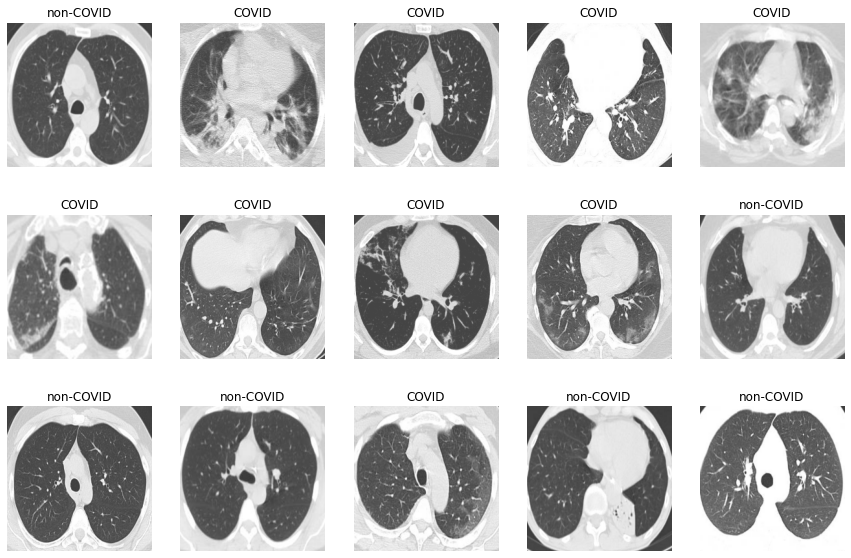

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_data.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[int(labels[i].numpy()[0])])
    plt.axis(False)

## Data Augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1/255.0) # No need in effiecientnet, needed in mobilenet
], name='data_augmentation')

In [ ]:
# Setup the model 
# Create a base model of efficientnetb7, by defult the color channel must be 3.
base_model = tf.keras.applications.densenet.DenseNet121(include_top=False)

# Freeze the layers of base model
base_model.trainable = False

# Create an input layer
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,),
                              #  batch_size=BATCH_SIZE,
                               name='input_layer')

# Augment the inputs layers output
x = data_augmentation(inputs)

# Pass the inputs to the base model
x = base_model(inputs)

# Create the GlobalAveragePooling2D layers, which normalizes the values between 0 & 1.
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Create the output Dense layer having two units.
outputs = tf.keras.layers.Dense(units=len(train_data.class_names) -1, 
                                activation='sigmoid',
                                name='output_layer')(x)

# Now Create the model and pass the inputs and output 
model = tf.keras.Model(inputs, outputs)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling_laye  (None, 1024)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

In [ ]:
# Number of layers in the base model and which layers are trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
# Now compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Creating earlystopping callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5)


# Creating ModelCheckpoint callbacks.

In [ ]:
# Fit the model on the train data for 10 epochs
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=10,
                    validation_data=test_data,
                    validation_steps=int(0.2 * len(test_data)),
                    callbacks=[early_stopping_callback])

Epoch 1/10
66/66 [==============================] - 33s 216ms/step - loss: 0.7013 - accuracy: 0.6984 - val_loss: 0.5154 - val_accuracy: 0.7344
Epoch 2/10
66/66 [==============================] - 9s 119ms/step - loss: 0.4932 - accuracy: 0.7762 - val_loss: 0.4427 - val_accuracy: 0.7500
Epoch 3/10
66/66 [==============================] - 10s 129ms/step - loss: 0.4271 - accuracy: 0.8137 - val_loss: 0.3682 - val_accuracy: 0.8438
Epoch 4/10
66/66 [==============================] - 10s 136ms/step - loss: 0.3927 - accuracy: 0.8274 - val_loss: 0.3502 - val_accuracy: 0.8438
Epoch 5/10
66/66 [==============================] - 10s 135ms/step - loss: 0.3624 - accuracy: 0.8402 - val_loss: 0.3347 - val_accuracy: 0.8281
Epoch 6/10
66/66 [==============================] - 10s 134ms/step - loss: 0.3507 - accuracy: 0.8516 - val_loss: 0.3138 - val_accuracy: 0.9219
Epoch 7/10
66/66 [==============================] - 9s 121ms/step - loss: 0.3271 - accuracy: 0.8634 - val_loss: 0.3143 - val_accuracy: 0.9219
E

In [ ]:
model.evaluate(test_data)

12/12 [==============================] - 3s 225ms/step - loss: 0.3260 - accuracy: 0.8710


[0.3260238468647003, 0.8709677457809448]

## Fine-Tune the model

In [ ]:
# Unfreeze the last 20 layers of the base model
base_model.trainable = True

for layer in model.layers[1].layers[-10:]:
  layer.trainable = True

# Re-compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Fit the model
history_fine_tuned = model.fit(train_data,
                               epochs=100,
                               validation_data=test_data,
                               validation_steps=int(0.2 * len(test_data)),
                               callbacks=[early_stopping_callback])

Epoch 1/100
66/66 [==============================] - 89s 395ms/step - loss: 0.1352 - accuracy: 0.9602 - val_loss: 1.2556 - val_accuracy: 0.8125
Epoch 2/100
66/66 [==============================] - 25s 362ms/step - loss: 0.0289 - accuracy: 0.9896 - val_loss: 1.6893 - val_accuracy: 0.7969
Epoch 3/100
66/66 [==============================] - 25s 360ms/step - loss: 0.0332 - accuracy: 0.9891 - val_loss: 0.0431 - val_accuracy: 0.9844
Epoch 4/100
66/66 [==============================] - 25s 364ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.0759 - val_accuracy: 0.9531
Epoch 5/100
66/66 [==============================] - 25s 359ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0479 - val_accuracy: 0.9844
Epoch 6/100
66/66 [==============================] - 25s 359ms/step - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0261 - val_accuracy: 0.9844
Epoch 7/100
66/66 [==============================] - 24s 358ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0167 - val_accuracy:

## Evaluate the model on the complete test data i.e. 100% test data

In [ ]:
result_fine_tuned = model.evaluate(test_data)
result_fine_tuned

12/12 [==============================] - 3s 231ms/step - loss: 0.0404 - accuracy: 0.9892


[0.04040166735649109, 0.9892473220825195]

In [ ]:
# Predicting the results of the test data
y_preds = model.predict(test_data)
y_preds[:10]

12/12 [==============================] - 3s 126ms/step


array([[9.9999952e-01],
       [1.0000000e+00],
       [5.0881781e-13],
       [8.2076857e-17],
       [1.8890355e-15],
       [1.7438773e-10],
       [8.7640556e-10],
       [9.9999261e-01],
       [9.9999940e-01],
       [9.5583753e-05]], dtype=float32)

In [ ]:
y_pred = []
for i in y_preds:
  if i > 0.50:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred[:10]

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and label
 y_labels.append(int(labels.numpy()[0])) # append the index which has the largest value (
y_labels[:10] # check what they look like (unshuffled)

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
import numpy as np
np.concatenate((np.array(y_labels).reshape(len(y_pred), 1), np.array(y_pred).reshape(len(y_pred), 1)), axis=1)

array([[1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0,

In [ ]:
# Counting the number of wrong prediction and the total size of the test data.
new = np.array(y_labels).reshape(len(y_pred), 1) == np.array(y_pred).reshape(len(y_pred), 1)
list(new).count(False), len(list(new))

(4, 372)

In [ ]:
# Getting the classification score 
from sklearn.metrics import classification_report
classification_report = classification_report(y_labels, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       201
           1       0.99      0.99      0.99       171

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



In [ ]:
# Getting the accuracy score using scikit-learn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, y_pred)
accuracy

0.989247311827957

In [ ]:
# Getting the f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_labels, y_pred)
f1_score

0.9883040935672515

In [ ]:
# Making the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_labels, y_pred)
confusion_matrix

array([[199,   2],
       [  2, 169]])

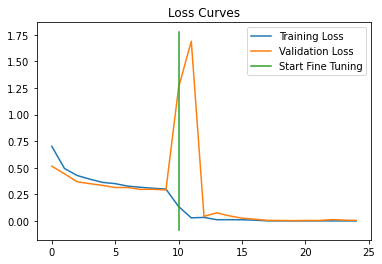

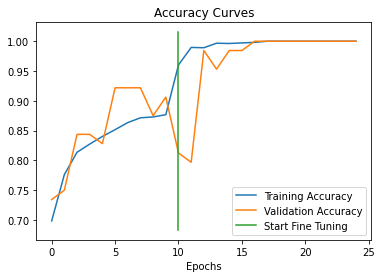

In [ ]:
# Plot the loss and accuracy curves
import matplotlib.pyplot as plt

# Getting the loss values from the history 
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Total loss
total_loss = loss + history_fine_tuned.history['loss']
total_val_loss = val_loss + history_fine_tuned.history['val_loss']

# Total accuracy
total_accuracy = accuracy + history_fine_tuned.history['accuracy']
total_val_accuracy = val_accuracy + history_fine_tuned.history['val_accuracy']

# epochs
epochs = range(len(history.history['loss'] + history_fine_tuned.history['loss']))



# Plot the loss curves
plt.plot(epochs, total_loss, label='Training Loss')
plt.plot(epochs, total_val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.plot([10, 10],
        plt.ylim(), label='Start Fine Tuning')
plt.legend()

# Plot the accuracy curves
plt.figure()
plt.plot(epochs, total_accuracy, label='Training Accuracy')
plt.plot(epochs, total_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.plot([10, 10],
        plt.ylim(), label='Start Fine Tuning')
plt.legend()


## Save the Trained Model and Load it

In [ ]:
# Save the model 
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
loaded_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling_laye  (None, 1024)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
result_loaded_model = loaded_model.evaluate(test_data)
result_loaded_model

12/12 [==============================] - 2s 117ms/step - loss: 0.0404 - accuracy: 0.9892


[0.04040166735649109, 0.9892473220825195]

In [ ]:
result_loaded_model == result_fine_tuned

True

## Download the model to your local machine

In order to download a folder from the colab runtime we need to:
1. Compress the folder (i.e. zip the file or folder)
2. Download the zip file .

In [ ]:
# 1. Zip the file
!zip saved_model.zip saved_model/my_model/*

updating: saved_model/my_model/assets/ (stored 0%)
updating: saved_model/my_model/fingerprint.pb (stored 0%)
updating: saved_model/my_model/keras_metadata.pb (deflated 96%)
updating: saved_model/my_model/saved_model.pb (deflated 92%)
updating: saved_model/my_model/variables/ (stored 0%)


In [ ]:
# 2. Download the file
from google.colab import files
files.download("saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>